In [9]:
import importlib
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.transforms as tr
import niftiutils.registration as regs
import os
import numpy as np
import pandas as pd
import pylab
import spect_fxns as sf
import skimage.feature
import skimage.transform
%matplotlib inline

In [188]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(regs)
importlib.reload(sf)

<module 'spect_fxns' from 'C:\\Users\\Clinton\\Documents\\spect-assessment\\spect_fxns.py'>

In [3]:
phantom_dose = 12.53449 * 37 #MBq

spect_img, _ = hf.dcm_load_special("Z:\\Isa\\spect\\Phantom.dcm")

phantom_dose / np.sum(spect_img)

2.124045658798332e-05

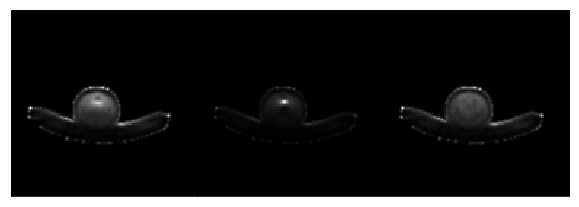

In [5]:
hf.draw_slices(spect_img, width=10)

In [14]:
maxes = np.amax(spect_img, axis=2)
mins = np.amin(spect_img, axis=2)
means = np.mean(spect_img, axis=2)
stds = np.std(spect_img, axis=2)

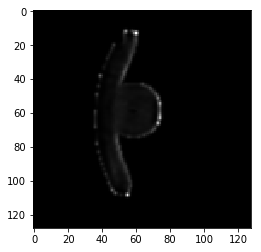

In [20]:
pylab.imshow(mins, cmap='gray')#, vmax=1000)

In [1]:
import scipy.ndimage

In [ ]:
spect_img

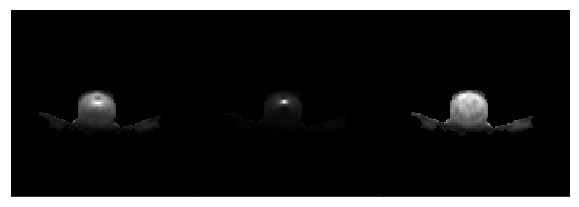

In [44]:
z = np.unravel_index((mins < np.mean(mins)), 2)[0] # & (stds > np.mean(stds))
z2 = scipy.ndimage.binary_dilation(z, iterations=4)
spect_filter = np.transpose(np.array([~z2*spect_slice for spect_slice in np.transpose(spect_img, (2,0,1))]), (1,2,0))
hf.draw_slices(spect_filter, width=10)

In [45]:
np.sum(spect_filter)

12624739

In [70]:
def reg_ct(ct_path, mri_nii_path):
    mri_img, mri_dims = hf.dcm_load(mri_path, True, True)
    hf.save_nii(mri_img, mri_nii_path, mri_dims)
    #hf.draw_slices(np.transpose(mri_img, (1,2,0)), width=10)
    
    ct_img, ct_dims = hf.dcm_load(ct_path, True, True)
    ct_img = tr.apply_window(ct_img)
    ct_img -= np.amin(ct_img)
    mri_real_size = [mri_img.shape[i] * mri_dims[i] for i in range(3)]
    ct_real_size = [ct_img.shape[i] * ct_dims[i] for i in range(3)]
    crops = [int((ct_real_size[i]-mri_real_size[i])//(ct_dims[i]*2)) for i in range(3)]
    z_shift = crops[2]//3*2

    ct_img_cropped = ct_img[crops[0]:-crops[0],crops[1]:-crops[1],crops[2]*2-z_shift:-z_shift]
    #ct_img, _ = tr.rescale_img(ct_img, mri_dims, ct_dims)
    #ct_dims = mri_dims
    hf.save_nii(ct_img_cropped, ct_nii_path, ct_dims)
    #hf.draw_slices(np.transpose(ct_img_cropped, (1,2,0)), width=10)
    settings = {'iterations': '25', 'resolution': '1.5'}
    regs.reg_bis(mri_nii_path, ct_nii_path, ct_mr_transform_path, ct_reg_path)#, settings=settings)
    
    return ct_img_cropped

In [71]:
def reg_fused(fused_path, ct_nii_path):
    fused_img, _ = hf.dcm_load_special(fused_path)
    fused_img = fused_img[:,::-1,::-1]
    fused_img = np.min(fused_img, axis=3).astype('float64')
    fused_img, _ = tr.rescale_img(fused_img, ct_img_cropped.shape)
    fused_img_cropped = fused_img[70:-70,80:-80,20:-10]
    hf.save_nii(fused_img_cropped, fused_nii_path, ct_dims)
    #hf.draw_slices(np.transpose(fused_img[70:-70,80:-80,20:-10], (1,2,0)), width=10)

    #settings = {'mode': 'affine', 'numberofbins': '8', 'iterations': '25'}
    regs.reg_bis(ct_nii_path, fused_nii_path, fused_ct_transform_path, fused_reg_path)#, settings=settings)
    regs.transform_bis(fused_reg_path, ct_mr_transform_path, mri_nii_path, fused_reg2_path)

In [17]:
patient_ids[6:]

array([15, 20, 21, 22, 23, 28, 29, 34], dtype=int64)

In [18]:
for patient_id in patient_ids[6:]:
    spect_dir = os.path.join(base_dir, "spect", df.loc[patient_id]["SPECT"])
    spect_path = os.path.join(spect_dir, [fn for fn in os.listdir(spect_dir) if 'recon - ac' in fn][0])
    spect_img, _ = hf.dcm_load_special(spect_path)
    print(patient_id, np.sum(spect_img))

15 549180018 [4.7951998710632, 4.7951998710632, 4.7951998710632]
20 284727843 [4.7951998710632, 4.7951998710632, 4.7951998710632]
21 488160014 [4.7951998710632, 4.7951998710632, 4.7951998710632]
22 351222976 [4.7951998710632, 4.7951998710632, 4.7951998710632]
23 896032932 [4.7951998710632, 4.7951998710632, 4.7951998710632]
28 741620846 [4.7951998710632, 4.7951998710632, 4.7951998710632]
29 659087464 [4.7951998710632, 4.7951998710632, 4.7951998710632]
34 782303076 [4.7951998710632, 4.7951998710632, 4.7951998710632]


In [72]:
def reg_spect(spect_path, fused_path, spect_reg3_path, ct_img_cropped):
    spect_img, spect_dims = hf.dcm_load_special(spect_path)
    spect_img = spect_img[:,::-1,:]
    spect_img = spect_img.astype('float64')
    spect_img, _ = tr.rescale_img(spect_img, ct_img_cropped.shape)
    spect_img_cropped = spect_img[70:-70,80:-80,20:-10]
    hf.save_nii(spect_img_cropped, spect_nii_path, ct_dims)

    #hf.draw_slices(np.transpose(spect_img_cropped, (1,2,0)), width=10)

    fused_img, _ = hf.dcm_load_special(fused_path)
    fused_img = fused_img[:,::-1,::-1]
    fused_img = (np.max(fused_img, axis=3) - np.min(fused_img, axis=3)).astype('float64')
    fused_img, _ = tr.rescale_img(fused_img, ct_img_cropped.shape)
    fused_img_cropped = fused_img[70:-70,80:-80,20:-10]
    hf.save_nii(fused_img_cropped, fused_nii_path, ct_dims)

    #hf.draw_slices(np.transpose(fused_img_cropped, (1,2,0)), width=10)

    regs.reg_bis(fused_nii_path, spect_nii_path, spect_fused_transform_path, spect_reg_path)#, settings=settings)
    regs.transform_bis(spect_reg_path, fused_ct_transform_path, ct_nii_path, spect_reg2_path)
    regs.transform_bis(spect_reg2_path, ct_mr_transform_path, mri_nii_path, spect_reg3_path)

In [ ]:
coverage_df = pd.DataFrame(columns=["BL-liver-%dosage", "BL-tumor-%dosage", "BL-enhancing-tumor-%dosage", "FU-liver-%dosage", "FU-tumor-%dosage", "FU-enhancing-tumor-%dosage"])

In [12]:
base_dir = "Z:\\Isa"
xls_out = r"Z:\Isa\Results.xlsx"
xls_fn = r"Z:\Isa\T1-Response-Desktop.xlsx"
#writer = pd.ExcelWriter(xls_fn)

df = pd.read_excel(xls_fn, index_col=0, dtype={"index": np.int32})
df.dropna(subset=["SPECT"], inplace=True)
df = df[df["Segmented"] == "Yes"]
patient_ids = df.index.values

mri_dir = os.path.join(patient_folder, [x for x in os.listdir(patient_folder) if ('MRI' in x and 'BL' in x) or df.loc[patient_id]['BL-MRI'] in x][0])

In [192]:
for patient_id in patient_ids[6:]:
    mri_path = os.path.join(base_dir, "blmri", str(df.loc[patient_id]["BL-MRI"]), "T1_AP")
    if not os.path.exists(mri_path):
        print(mri_path)
    mri_path = os.path.join(base_dir, "fumri", str(df.loc[patient_id]["FU1/2-MRI"]), "T1_AP")
    if not os.path.exists(mri_path):
        print(mri_path)

In [200]:
for patient_id in patient_ids[7:]:
    patient_folder = "Z:\\Isa\\binary etc\\"+str(patient_id)+"-S"

    spect_dir = os.path.join(base_dir, "spect", df.loc[patient_id]["SPECT"])
    ct_path = os.path.join(spect_dir, [fn for fn in os.listdir(spect_dir) if 'y90 sirs' in fn and 'ac' not in fn][0])
    fused_path = os.path.join(spect_dir, [fn for fn in os.listdir(spect_dir) if 'fused tran' in fn][0])
    spect_path = os.path.join(spect_dir, [fn for fn in os.listdir(spect_dir) if 'recon - ac' in fn][0])

    nii_path = os.path.join(base_dir, "nii_files", str(patient_id))

    fused_reg_path = os.path.join(nii_path, "fused-reg.nii")
    spect_reg_path = os.path.join(nii_path, "spect-reg.nii")

    fused_reg2_path = os.path.join(nii_path, "fused-reg2.nii")
    spect_reg2_path = os.path.join(nii_path, "spect-reg2.nii")

    ct_nii_path = os.path.join(nii_path, "ct.nii")
    spect_nii_path = os.path.join(nii_path, "spect.nii")
    fused_nii_path = os.path.join(nii_path, "fused.nii")

    ct_mr_transform_path = os.path.join(nii_path, "ct-mr.txt")
    fused_ct_transform_path = os.path.join(nii_path, "fused-ct.txt")
    spect_fused_transform_path = os.path.join(nii_path, "spect-fused.txt")
    ct_reg_path = os.path.join(nii_path, "ct-reg.nii")

    #mri_path = os.path.join(mri_dir, "vibe_fs_axial_dynamic_post_16sec_13")
    mri_path = os.path.join(base_dir, "blmri", str(df.loc[patient_id]["BL-MRI"]), "T1_AP")
    mri_nii_path = os.path.join(nii_path, "blmri.nii")
    spect_reg3_path = os.path.join(nii_path, "blspect-reg3.nii")

    ct_img_cropped = reg_ct(ct_path, mri_nii_path)
    reg_fused(fused_path, ct_nii_path)
    reg_spect(spect_path, fused_path, spect_reg3_path, ct_img_cropped)

    segs_dir = os.path.join(patient_folder, "BL-segs")
    if not os.path.exists(segs_dir):
        segs_dir = os.path.join(patient_folder, "segs")
        if not os.path.exists(segs_dir):
            print(segs_dir, "does not exist")

    mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if "BL" in x and "tumor" in x.lower() and x.endswith("ids")][0]
    tumor_mask, dims = masks.get_mask(mask_path)

    mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if "BL" in x and "liver" in x.lower() and x.endswith("ids")][0]
    liver_mask, dims = masks.get_mask(mask_path)

    try:
        mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if ("enh" in x.lower() or "viable" in x.lower()) and x.endswith("ids")][0]
        enh_mask, dims = masks.get_mask(mask_path)

        spect_reg, spect_dims = hf.nii_load(spect_reg3_path)

        BL_liver_cov = np.sum(spect_reg * liver_mask) / np.sum(spect_reg) * 100 / 255
        BL_tumor_cov = np.sum(spect_reg * tumor_mask) / np.sum(spect_reg) * 100 / 255
        BL_enh_cov = np.sum(spect_reg * enh_mask) / np.sum(spect_reg) * 100 / 255
    except:
        spect_reg, spect_dims = hf.nii_load(spect_reg3_path)

        BL_liver_cov = np.sum(spect_reg * liver_mask) / np.sum(spect_reg) * 100 / 255
        BL_tumor_cov = np.sum(spect_reg * tumor_mask) / np.sum(spect_reg) * 100 / 255
        BL_enh_cov = "Missing"

    mri_path = os.path.join(base_dir, "fumri", str(df.loc[patient_id]["FU1/2-MRI"]), "T1_AP")
    mri_nii_path = os.path.join(nii_path, "fumri.nii")
    spect_reg3_path = os.path.join(nii_path, "fuspect-reg3.nii")

    ct_img_cropped = reg_ct(ct_path, mri_nii_path)
    reg_fused(fused_path, ct_nii_path)
    reg_spect(spect_path, fused_path, spect_reg3_path, ct_img_cropped)

    segs_dir = os.path.join(patient_folder, "FU-segs")
    if not os.path.exists(segs_dir):
        segs_dir = os.path.join(patient_folder, "segs")
        if not os.path.exists(segs_dir):
            print(segs_dir, "does not exist")

    mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if "FU" in x and "tumor" in x.lower() and x.endswith("ids")][0]
    tumor_mask, dims = masks.get_mask(mask_path)

    mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if "FU" in x and "liver" in x.lower() and x.endswith("ids")][0]
    liver_mask, dims = masks.get_mask(mask_path)

    try:
        mask_path = segs_dir + "\\" + [x for x in os.listdir(segs_dir) if ("enh" in x.lower() or "viable" in x.lower()) and x.endswith("ids")][0]
        enh_mask, dims = masks.get_mask(mask_path)

        spect_reg, spect_dims = hf.nii_load(spect_reg3_path)

        FU_liver_cov = np.sum(spect_reg * liver_mask) / np.sum(spect_reg) * 100 / 255
        FU_tumor_cov = np.sum(spect_reg * tumor_mask) / np.sum(spect_reg) * 100 / 255
        FU_enh_cov = np.sum(spect_reg * enh_mask) / np.sum(spect_reg) * 100 / 255
    except:
        spect_reg, spect_dims = hf.nii_load(spect_reg3_path)

        FU_liver_cov = np.sum(spect_reg * liver_mask) / np.sum(spect_reg) * 100 / 255
        FU_tumor_cov = np.sum(spect_reg * tumor_mask) / np.sum(spect_reg) * 100 / 255
        FU_enh_cov = "Missing"

    coverage_df.loc[patient_id] = [BL_liver_cov, BL_tumor_cov, BL_enh_cov, FU_liver_cov, FU_tumor_cov, FU_enh_cov]

In [201]:
coverage_df

,BL-liver-%dosage,BL-tumor-%dosage,BL-enhancing-tumor-%dosage,FU-liver-%dosage,FU-tumor-%dosage,FU-enhancing-tumor-%dosage
4,30.484852,5.221436,Missing,34.179772,2.366506,Missing
3,53.009632,0.099645,Missing,51.569477,0.284876,Missing
5,40.422092,0.792324,Missing,43.844026,0.456986,Missing
6,36.899575,4.962842,Missing,48.471584,3.523664,Missing
8,14.110920,1.115818,Missing,25.979495,0.217305,Missing
15,21.932487,4.781764,Missing,55.620172,12.216929,Missing
20,33.749130,0.158867,Missing,29.037944,0.130804,Missing
21,4.616540,0.000000,Missing,13.147387,0.000107,Missing
22,18.105031,0.426217,Missing,26.802121,0.504556,Missing
23,51.141430,1.079490,Missing,47.403339,1.227742,Missing


In [202]:
coverage_df.to_excel(xls_out)

In [4]:
for patient_id in patient_ids:
    sf.check_dcm_paths(patient_id, df)

In [5]:
dcm_paths = {}
nii_paths = {}
mask_paths = {}

for patient_id in patient_ids:
    sf.set_paths(patient_id, df, dcm_paths, nii_paths, mask_paths)

In [6]:
patient_id = 3
nii_p = nii_paths[patient_id]

In [342]:
for patient_id in [3]:#patient_ids:
    sf.save_niis(patient_id, dcm_paths, nii_paths)

In [ ]:
for patient_id in [3]:#patient_ids:
    sf.reg_all_niis(patient_id, nii_paths)

nii_p = nii_paths[patient_id]

ct_img, dims = hf.dcm_load(dcm_paths[patient_id]['ct'])
hf.save_nii(ct_img, nii_p['ct'], dims)

blmri_art, dims = hf.dcm_load(dcm_paths[patient_id]['blmri-art'])
hf.save_nii(blmri_art, nii_p['blmri-art'], dims)

fused_img = hf.get_spect_series(dcm_paths[patient_id]['fused'])

#spect_head = hf.get_spect_series(dcm_paths[3]["fused"], just_header=True)

for accnum in ['E104191217','E102337624','E103524930','E101144756','E103674058','E101216308','E103467396','E102059019','E103283145','E101355783','E105722892','12973122','E100860542','E103113772','E102125758','E101783139','E104383547','E104114246','E102832434','E102446873','E102974401']:
    if not os.path.exists('Z:\\Isa\\spect\\'+accnum):
        print(accnum)

for patient_id in patient_ids:
    sf.get_stats(patient_id, nii_paths, mask_paths)

In [43]:
# register ct to blmri-art
out_img_path, blct_transform_path = sf.reg_nii("blmri-art", "ct", nii_p, overwrite=True)
print(out_img_path, blct_transform_path)
img = hf.ni_load(out_img_path)
hf.save_nii(img[0], out_img_path, img[1])
hf.plot_section_auto(img[0])

Z:\Isa\3\ct-reg.nii Z:\Isa\3\ct_blmri-art_xform.txt


Z:\Isa\3\fused-reg.nii Z:\Isa\3\fused_ct_xform.txt


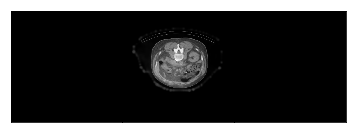

In [45]:
# register fused to ct
out_img_path, ctfused_transform_path = sf.reg_nii("ct", "fused", nii_p, overwrite=True)
print(out_img_path, ctfused_transform_path)
img = hf.ni_load(out_img_path)
hf.save_nii(img[0], out_img_path, img[1])
hf.plot_section_auto(img[0])

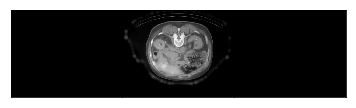

In [46]:
out_img_path = sf.transform_nii(out_img_path, [blct_transform_path], [nii_p["blmri-art"]],
                 out_img_path=hf.add_to_filename(nii_p['fused'],'-superreg'))
img = hf.ni_load(out_img_path)
hf.save_nii(img[0], out_img_path, img[1])
hf.plot_section_auto(img[0])

In [596]:
sf.transform_nii(temp_file, [ctfused_transform_path], hf.ni_load(nii_p["ct"]), out_img_path=temp_file, overwrite=True)
sf.transform_nii(temp_file, [blct_transform_path], hf.ni_load(nii_p["blmri-art"]), out_img_path=base_dir+"spect-reg.nii")

True

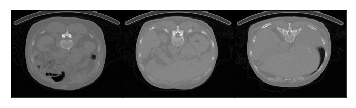

In [51]:
ct_reg,_=hf.ni_load(hf.add_to_filename(nii_p['ct'],'-reg'))
hf.plot_section_auto(ct_reg)
hf.create_threshold_mask(ct_reg, nii_p["base"]+"ct_reg_mask.ids",
                         np.mean(ct_reg), mask_paths[patient_id]["tumor-bl"])

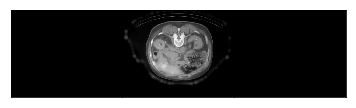

In [52]:
fused_reg,_=hf.ni_load(hf.add_to_filename(nii_p['fused'],'-superreg'))
hf.plot_section_auto(fused_reg)
hf.create_threshold_mask(fused_reg, nii_p["base"]+"fused_superreg_mask.ids",
                         np.mean(fused_reg), mask_paths[patient_id]["tumor-bl"])

In [601]:
spect_reg,_=hf.ni_load(hf.add_to_filename(nii_paths[patient_id]['spect'],'-reg'))
hf.plot_section_auto(spect_reg)
hf.create_threshold_mask(spect_reg, nii_paths[patient_id]["base"]+"spect-hi-thresh.ids",
                         255 * df.loc[patient_id,"high thresh"]/df.loc[patient_id, 'max intensity'],
                         mask_paths[patient_id]["tumor-bl"])

True

In [527]:
temp_path = "Z:\\temp.nii"

In [588]:
sf.reg_niis("fused-ch1", "spect", nii_p, out_img_path=temp_path, overwrite=True)

('Z:\\temp.nii', 'Z:\\Isa\\3\\spect_fused-ch1_transform.hdf5')

In [42]:
fixed_img_path = nii_p["blmri-art"]
moving_img_path = nii_p["ct"]
out_transform_path = nii_p["base"]+"ct_mr_transform.txt"
out_img_path = 

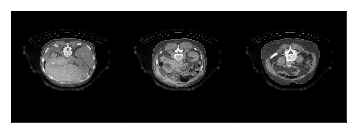

In [30]:
fused_img, _ = hf.ni_load(nii_p["fused"])
hf.plot_section_auto(fused)

In [85]:
reg_niis("blmri-art", "ct", nii_paths[patient_id], fixed_img=blmri_art, overwrite=True)

True

In [103]:
test, _ = hf.ni_load("test.nii")

In [ ]:
transform_niis(nii_p["fused-ch1"], ["ct_blmri-art"], nii_paths[patient_id], [blmri_art])

In [104]:
test.shape

(320, 250, 72)

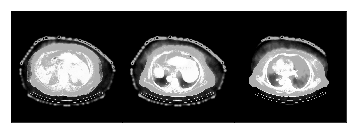

In [108]:
hf.plot_section_auto(test)

fumri_bl, _ = hf.dcm_load(dcm_paths[patient_id]['fumri-pre'])
fumri_bl = hf.reg_imgs(moving=fumri_bl, fixed=blmri_img, params=reg_params)
save_nii(fumri_bl, nii_paths[patient_id]["fumri-pre"])

In [ ]:
#spect_header = hf.get_spect_series(dcm_paths[patient_id]['spect'], just_header=True)
#rows = spect_header[('0028', '0010')].value
#cols = spect_header[('0028', '0011')].value
#frames = spect_header[('0028', '0008')].value

#print(patient_id, rows*cols*frames)
#df["voxels"] = 

In [207]:
df.to_excel(writer, sheet_name="Updated")
writer.save()

In [ ]:
for i in [3,5,14,15,16,24,28,29,34,20,21,22,23]: #os.listdir('Z:\\Isa')
    if str(df.loc[i]["SPECT"]) == "nan":
        continue
    spect_dir = 'Z:\\Isa\\spect\\' + str(df.loc[i]["SPECT"])
    for fn in os.listdir(spect_dir):
        if 'recon - ac' in fn:
            dcm_paths[patient_id]['spect'] = spect_dir + "\\" + fn
            print("found",i)
            spect_header = get_spect_series(dcm_paths[patient_id]['spect'], just_header=True)
            df.loc[i,'SPECT-Slope'] = spect_header[('0028', '1051')].value
            continue
        elif 'y90 sirs' in fn and 'ac' not in fn:
            dcm_paths[patient_id]['ct'] = spect_dir + "\\" + fn
        elif 'fused trans' in fn:
            dcm_paths[patient_id]['fused'] = spect_dir + "\\" + fn

In [91]:
mask_file = mask_paths[patient_id]["necrosis-fu"]

In [ ]:
fn_base = mask_file[:mask_file.find('.')]

with open(mask_file, 'rb') as f:
    mask = f.read()
    mask = np.fromstring(mask, dtype='uint8')
    mask = np.array(mask).reshape(orig_dims[::-1])
    mask = np.transpose(mask, (2,1,0))
    mask = mask/255
    mask, _ = hf.rescale(mask, dims)

with open(mask_file[:mask_file.find('.')]+"-scaled.ids", 'rb') as f:
    mask = round(mask) * 255
    f.write(mask)
    
mask = np.transpose(mask, (2,1,0))

importlib.reload(hf)

m, _ = hf.rescale(mask, dims)
with open(fn_base + "-scaled.ids", 'wb') as f:
    f.write(mask)

In [ ]:
hf.rescale_mask(mask_paths[patient_id]["necrosis-fu"], fumri_img.shape, blmri_bl.shape)
hf.rescale_mask(mask_paths[patient_id]["viable-tumor-fu"], fumri_img.shape, blmri_bl.shape)

In [79]:
total_dosage = np.sum(spect_img_reg)
tumor_dosage = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["tumor"]))
necro_dosage_bl = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["necrosis-bl"]))
viable_tumor_dosage_bl = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["viable-tumor-bl"]))
necro_dosage_fu = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["necrosis-fu"]))
viable_tumor_dosage_fu = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["viable-tumor-fu"]))

In [ ]:
plt.hist(spect_img)

In [ ]:
def get_dosage(df, spect_img_reg, mask):
    """Calculates dosage contained in mask by summing intensities in the registered spect_img.
    Assumes that intensity is linearly proportional to concentration."""

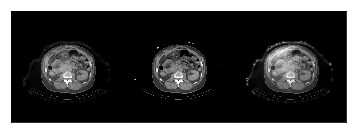

In [231]:
hf.plot_section_auto(fused_img)

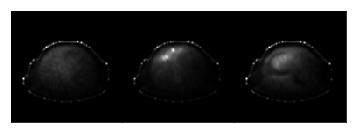

In [242]:
hf.plot_section_auto_1ch(spect_img)